# DM задача

In [108]:
from cgtasknet.instruments.instrument_subgroups import SubgroupFinder
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch


from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.tasks.reduce import (
    DMTaskParameters,
    DMTask,
)
from tqdm import tqdm
from cgtasknet.net import SNNlifadexrefrac
from norse.torch import LIFAdExRefracParameters, LIFAdExParameters

In [176]:
feature_size = 4
output_size = 3
hidden_size = 450
batch_size = 1
tau_ada_inv_distrib = np.load(
    "..\\..\\..\\models\\dm_and_romo\\lif_adex_refrac\\dm_and_romo_reduce_adex_refrac_450_95_percents_2000_epochs_alpha=100.npy"
)

neuron_parameters = LIFAdExRefracParameters(
    LIFAdExParameters(
        v_th=torch.as_tensor(0.65),
        tau_ada_inv=torch.from_numpy(tau_ada_inv_distrib),
        alpha=30,
        # method='heavi_erfc',
        method="super",
    ),
    rho_reset=torch.as_tensor(1),
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadexrefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
)
if True:
    model.load_state_dict(
        torch.load(
            "..\\..\\..\\models\\dm_and_romo\\lif_adex_refrac\\dm_and_romo_reduce_adex_refrac_450_95_percents_2000_epochs_alpha=100"
        )
    )
number_of_tasks = 1

In [177]:
all_answ_time = 0.1
all_trial_time = 0.6

In [178]:
dt = 1e-3
subgroup_finder = SubgroupFinder(dt)
init_state = LIFAdExRefracInitState(batch_size, hidden_size)
first_state = init_state.random_state()

for i in tqdm(range(number_of_tasks)):
    dmparams1 = DMTaskParameters(
        trial_time=all_trial_time,
        value=np.random.uniform(0, 0.4),
        answer_time=all_answ_time,
    )
    task = DMTask(dmparams1, mode="value")
    inputs, t_outputs = task.dataset(1)
    rule_matrix = np.zeros((inputs.shape[0], 1, 2))
    rule_matrix[:, :, 0] = 1
    inputs = np.concatenate((inputs, rule_matrix), axis=2)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    out, states = model(inputs, first_state)
    s = []
    for j in range(len(states)):
        s.append(states[j].lif_adex.z)
    s = torch.stack(s).detach()
    s = s.reshape((s.shape[0], s.shape[2]))
    subgroup_finder.compute_average_freq([s], [inputs[:, 0, 0]], [out], [t_outputs])

100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


In [179]:
dt = 1e-3
subgroup_finder2 = SubgroupFinder(dt)
init_state = LIFAdExRefracInitState(batch_size, hidden_size)
first_state = init_state.random_state()

for i in tqdm(range(number_of_tasks)):
    dmparams1 = DMTaskParameters(
        trial_time=all_trial_time,
        value=np.random.uniform(0.6, 1.001),
        answer_time=all_answ_time,
    )
    task = DMTask(dmparams1, mode="value")
    inputs, t_outputs = task.dataset(1)
    rule_matrix = np.zeros((inputs.shape[0], 1, 2))
    rule_matrix[:, :, 0] = 1
    inputs = np.concatenate((inputs, rule_matrix), axis=2)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    out, states = model(inputs, first_state)
    s = []
    for j in range(len(states)):
        s.append(states[j].lif_adex.z)
    s = torch.stack(s).detach()
    s = s.reshape((s.shape[0], s.shape[2]))
    subgroup_finder2.compute_average_freq([s], [inputs[:, 0, 0]], [out], [t_outputs])

100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


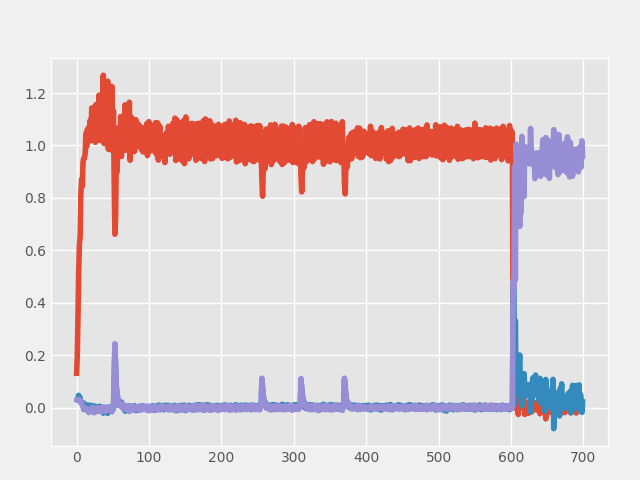

In [180]:
plt.figure()
plt.plot(out.detach().cpu().numpy()[:, 0, 0])
plt.show()

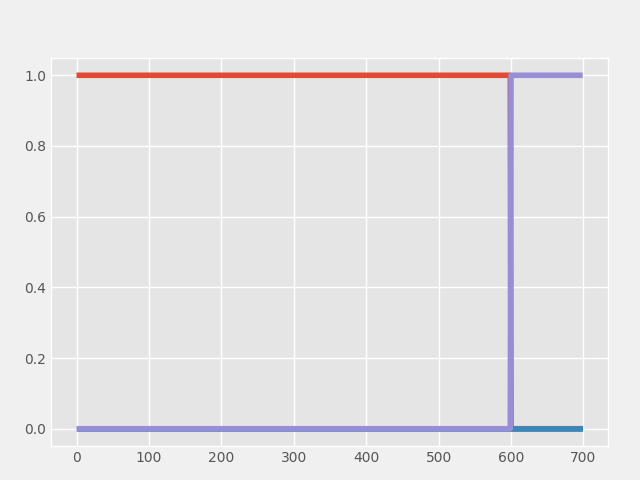

In [174]:
plt.figure()
plt.plot(t_outputs.detach().cpu().numpy()[:, 0])
plt.show()

In [175]:
for name, params in model.named_parameters():
    if name == "exp_f.linear.weight":
        out_weights = torch.clone(params.detach())

In [117]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_first, answer_first = subgroup_finder.get_average_freq()
fixation_second, answer_second = subgroup_finder2.get_average_freq()
strenght_first = answer_first * out_weights[1, :]
strenght_second = answer_second * out_weights[2, :]
strenght_first_freq_second_out = answer_first * out_weights[2, :]
strenght_second_freq_first_out = answer_second * out_weights[1, :]

strenght_first_freq_fixation = fixation_first * out_weights[1, :]
strenght_second_freq_fixation = fixation_second * out_weights[2, :]
strenght_first_freq_second_out_fixation = fixation_first * out_weights[2, :]
strenght_second_freq_first_out_fixation = fixation_second * out_weights[1, :]

strenght_first_sort = sort_elemnts_by_another(strenght_first, strenght_first)
strenght_second_sort = sort_elemnts_by_another(strenght_first, strenght_second)
strenght_first_freq_second_out_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_second_out
)
strenght_second_freq_first_out_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_first_out
)

strenght_first_freq_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_fixation
)
strenght_second_freq_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_fixation
)
strenght_first_freq_second_out_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_second_out_fixation
)
strenght_second_freq_first_out_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_first_out_fixation
)

In [139]:
plt.style.use("ggplot")


def plot_hist(data, c="#003153", alpha=1):
    x = np.arange(0, len(data), 1)
    for i in range(len(data)):
        plt.plot([x[i]] * 2, [0, data[i]], c=c, alpha=alpha, linewidth=0.5)

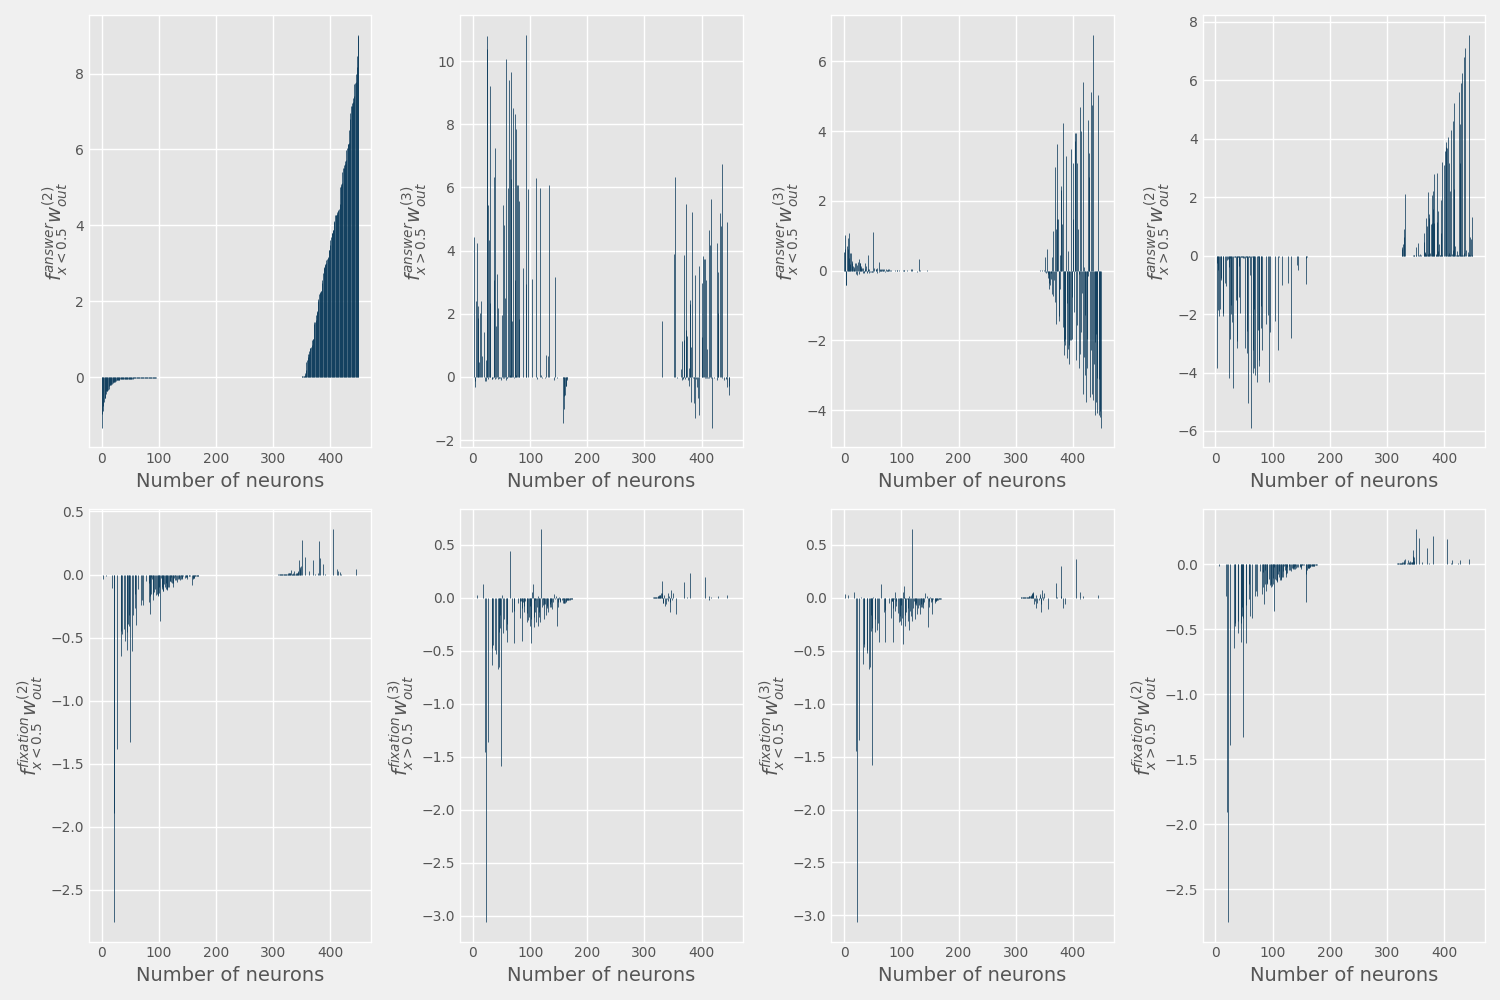

In [140]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
%matplotlib widget
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(15, 10))
plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plt.ylabel(r"$f^{answer}_{x > 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_sort.numpy())

plt.subplot(243)
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_second_out_sort.numpy())

plt.subplot(244)
plt.ylabel(r"$f^{answer}_{x > 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_first_out_sort.numpy())

plt.subplot(245)
plt.ylabel(r"$f^{fixation}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_fixation_sort.numpy())

plt.subplot(246)
plt.ylabel(r"$f^{fixation}_{x > 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_fixation_sort.numpy())


plt.subplot(247)
plt.ylabel(r"$f^{fixation}_{x < 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_second_out_fixation_sort.numpy())

plt.subplot(248)

plt.ylabel(r"$f^{fixation}_{x > 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_first_out_fixation_sort.numpy())
plt.tight_layout()
# plt.savefig("freq_strenght.pdf")
plt.show()

In [141]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_first, answer_first = subgroup_finder.get_average_freq()
fixation_second, answer_second = subgroup_finder2.get_average_freq()
# strenght_first = answer_first * out_weights[1, :]
fixation_first_sort = sort_elemnts_by_another(strenght_first, fixation_first)
fixation_second_sort = sort_elemnts_by_another(strenght_first, fixation_second)
answer_first_sort = sort_elemnts_by_another(strenght_first, answer_first)
answer_second_sort = sort_elemnts_by_another(strenght_first, answer_second)
out1_sort = sort_elemnts_by_another(strenght_first, out_weights[0, :])
out2_sort = sort_elemnts_by_another(strenght_first, out_weights[1, :])
out3_sort = sort_elemnts_by_another(strenght_first, out_weights[2, :])

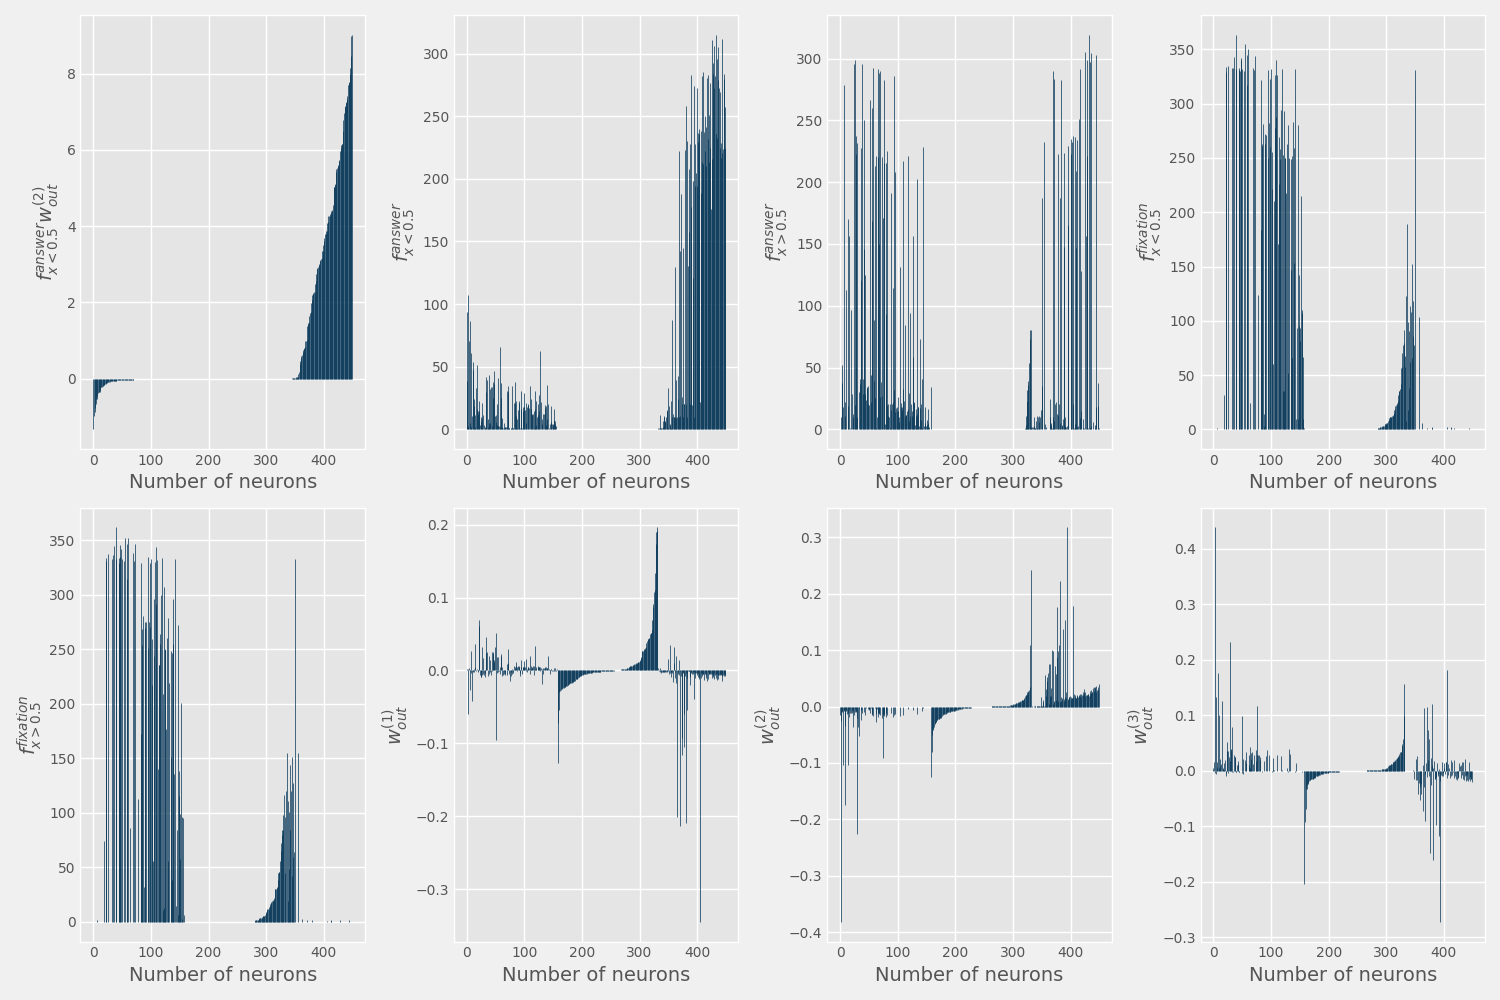

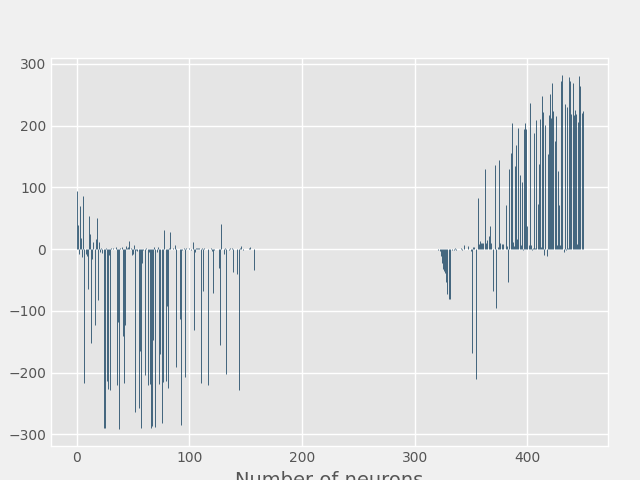

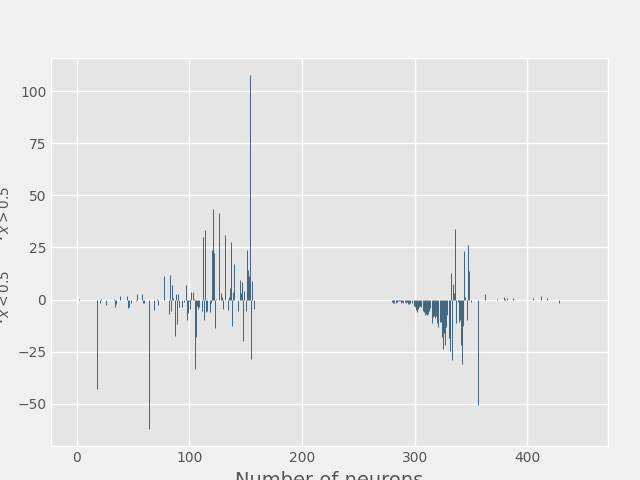

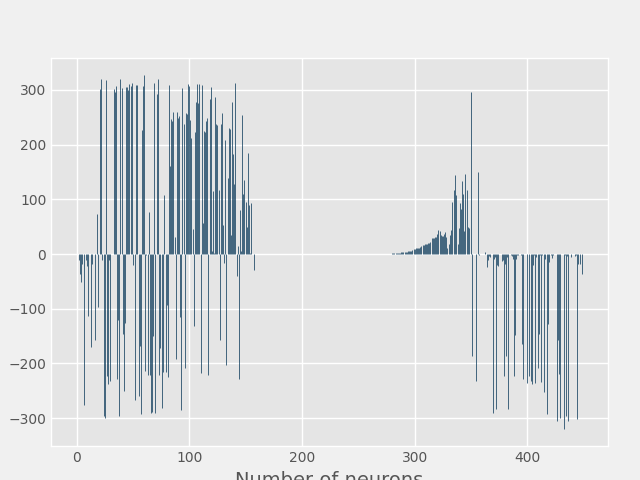

In [142]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(15, 10))


plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plot_hist(answer_first_sort.numpy())


plt.ylabel(r"$f^{answer}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(243)
plot_hist(answer_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(244)
plot_hist(fixation_first_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(245)
plot_hist(fixation_second_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(246)
plot_hist(out1_sort.numpy())
plt.ylabel(r"${w_{out}^{(1)}}$")
plt.xlabel("Number of neurons")

plt.subplot(247)
plot_hist(out2_sort.numpy())
plt.ylabel(r"${w_{out}^{(2)}}$")
plt.xlabel("Number of neurons")


plt.subplot(248)
plot_hist(out3_sort.numpy())
plt.ylabel(r"${w_{out}^{(3)}}$")
plt.xlabel("Number of neurons")


plt.tight_layout()
# plt.savefig("freq.pdf")
plt.show()

plt.figure()
plot_hist(answer_first_sort.numpy() - answer_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} - f^{answer}_{x > 0.5}$")
plt.xlabel("Number of neurons")
plt.show()

plt.figure()
plot_hist(fixation_first_sort.numpy() - fixation_second_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x < 0.5} - f^{fixation}_{x > 0.5}$")
plt.xlabel("Number of neurons")
plt.show()

plt.figure()
plot_hist(fixation_second_sort.numpy() - answer_second_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x > 0.5} - f^{answer}_{x > 0.5}$")
plt.xlabel("Number of neurons")
plt.show()

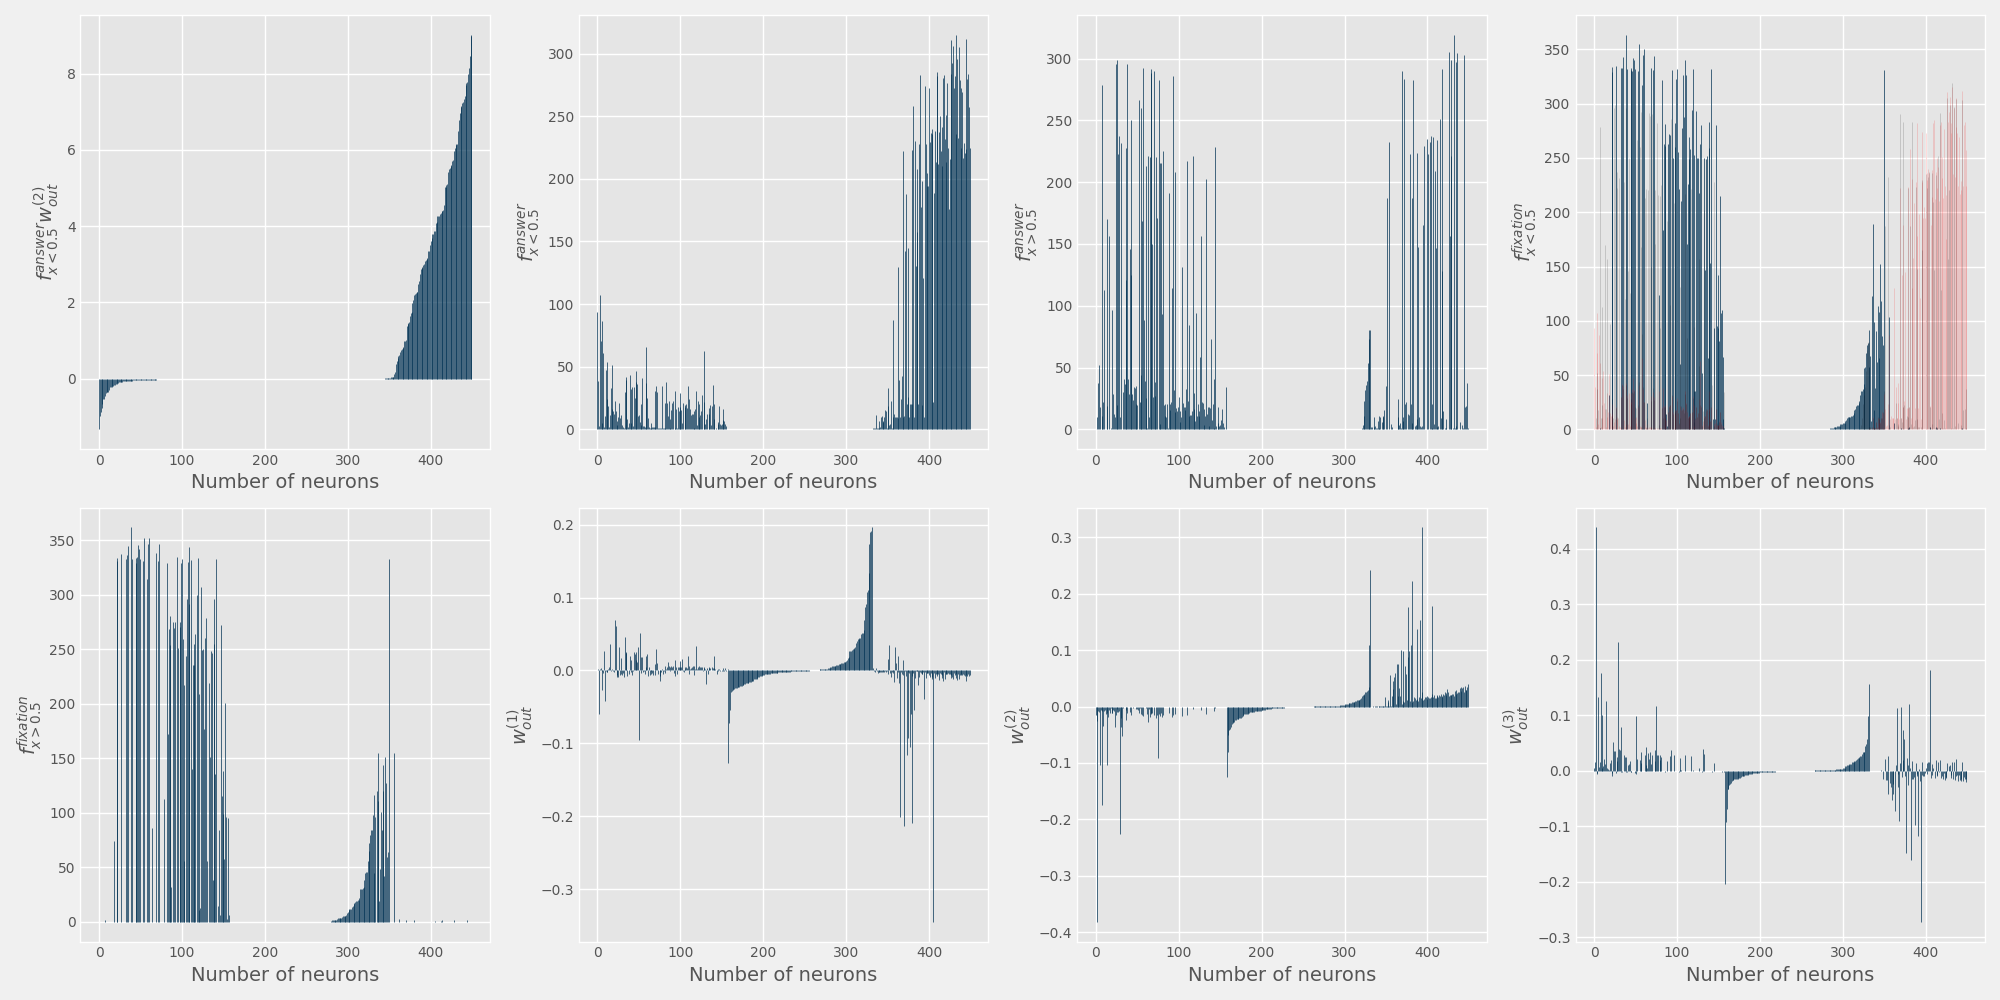

In [143]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))


plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plot_hist(answer_first_sort.numpy())


plt.ylabel(r"$f^{answer}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(243)
plot_hist(answer_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(244)
plot_hist(fixation_first_sort.numpy())
plot_hist(answer_first_sort.numpy(), c="r", alpha=0.2)
plot_hist(answer_second_sort.numpy(), c="black", alpha=0.2)

plt.ylabel(r"$f^{fixation}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(245)
plot_hist(fixation_second_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(246)
plot_hist(out1_sort.numpy())
plt.ylabel(r"${w_{out}^{(1)}}$")
plt.xlabel("Number of neurons")

plt.subplot(247)
plot_hist(out2_sort.numpy())
plt.ylabel(r"${w_{out}^{(2)}}$")
plt.xlabel("Number of neurons")


plt.subplot(248)
plot_hist(out3_sort.numpy())
plt.ylabel(r"${w_{out}^{(3)}}$")
plt.xlabel("Number of neurons")


plt.tight_layout()
# plt.savefig("freq.pdf")
plt.show()

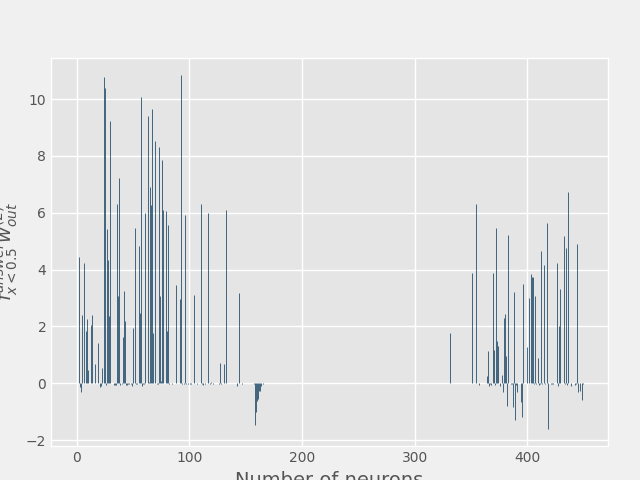

In [144]:
%matplotlib widget
plt.figure()
plot_hist(strenght_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.show()

In [145]:
for name, params in model.named_parameters():
    print(name)
    if name == "adexrefrac.recurrent_weights":
        rec_weights = torch.clone(params.detach())

list_numbers = [i for i in range(len(rec_weights))]

adexrefrac.input_weights
adexrefrac.recurrent_weights
exp_f.linear.weight
exp_f.linear.bias


In [146]:
for name, params in model.named_parameters():
    if name == "adexrefrac.input_weights":
        input_weights = torch.clone(params.detach())

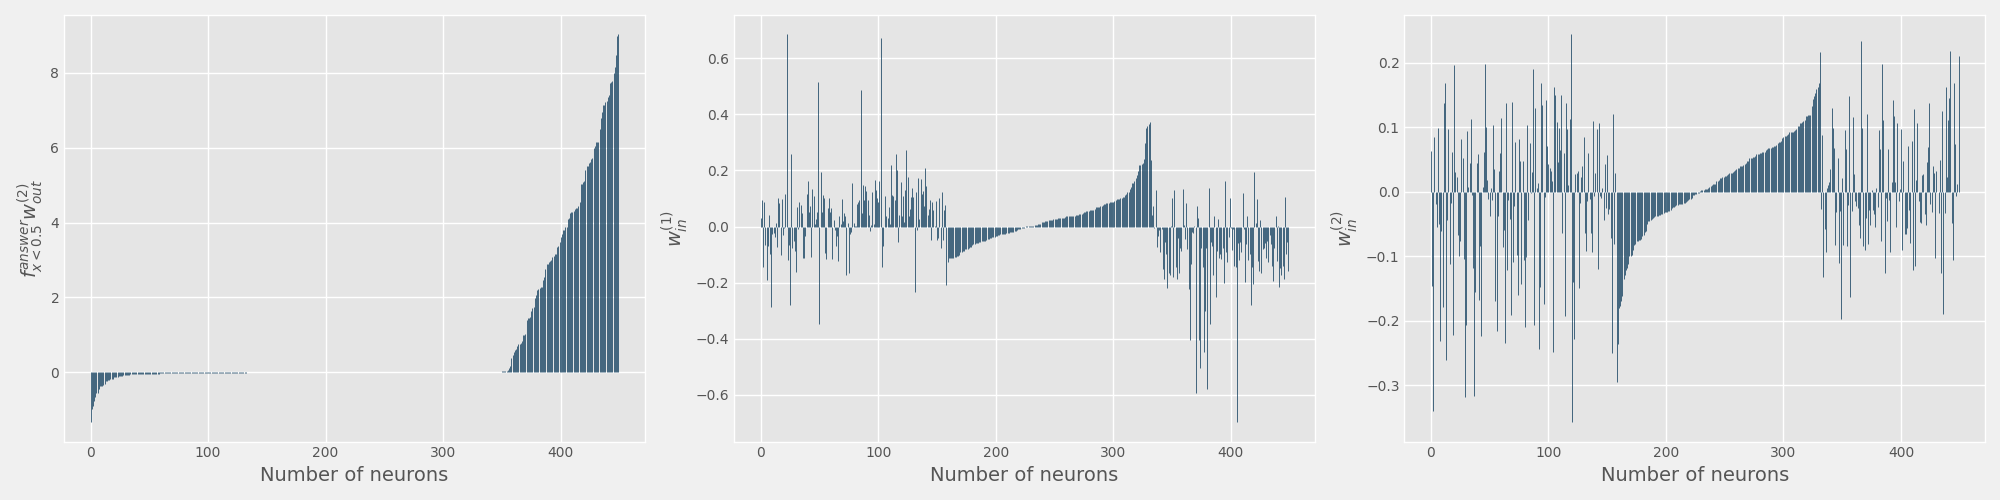

In [147]:
input_sort_1 = sort_elemnts_by_another(strenght_first, input_weights[:, 0])
input_sort_2 = sort_elemnts_by_another(strenght_first, input_weights[:, 1])

plt.figure(figsize=(20, 5))
plt.subplot(131)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.subplot(132)
plot_hist(input_sort_1.numpy())
plt.ylabel(r"$w_{in}^{(1)}$")
plt.xlabel("Number of neurons")
plt.subplot(133)
plot_hist(input_sort_2.numpy())
plt.ylabel(r"$w_{in}^{(2)}$")
plt.xlabel("Number of neurons")
plt.tight_layout()
# plt.savefig("w_in.pdf")
plt.show()

C:\Users\slava\AppData\Local\Temp/ipykernel_21140/64998773.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("rec_w", interpolation="None")


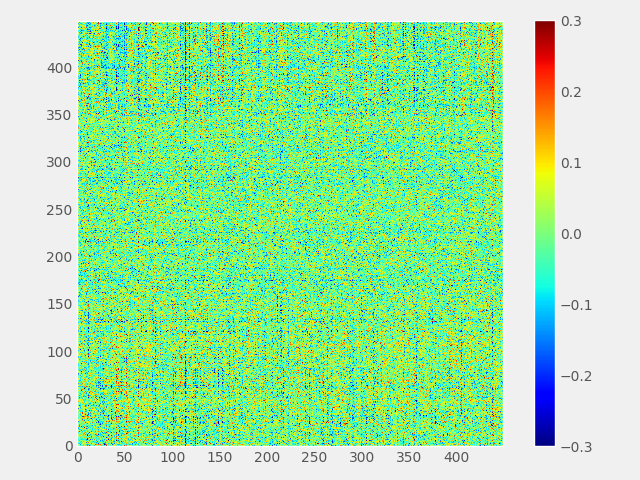

In [154]:
%matplotlib widget
list_sum_out_weights = []
strenght_first = answer_first * out_weights[1, :]

list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)
rec_weights_sort = torch.zeros_like(rec_weights)

for i in range(len(list_numbers)):
    rec_weights_sort[i] = rec_weights[list_numbers_sort[i]]
plt.figure()
plt.imshow(
    (rec_weights_sort.numpy()),
    cmap="jet",
    origin="lower",
    interpolation="None",
    vmin=-0.3,
    vmax=0.3,
)
plt.colorbar()
plt.tight_layout()
plt.savefig("rec_w", interpolation="None")
plt.grid(False)
plt.show()

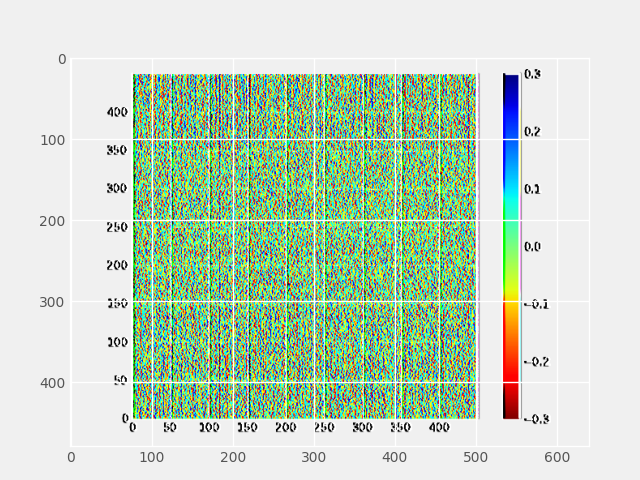

In [155]:
import cv2

img = cv2.imread("rec_w.png", 1)
kernel = np.array([[-0, 0, 1], [-3, 0, 3], [-4, 0, 4]], dtype=np.float32)
dst = cv2.filter2D(img, -1, kernel)
plt.figure()
plt.imshow(dst)
plt.show()

# SELECTIVITY

In [165]:
dt = 1e-3

init_state = LIFAdExRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
values = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
Neurons_frequency_fixation = np.zeros((hidden_size, len(values)))
Neurons_frequency_answer = np.zeros((hidden_size, len(values)))
number_of_tasks = 200
for value_i in tqdm(range(len(values))):
    subgroup_finder_choose = SubgroupFinder(dt)
    for i in range(number_of_tasks):

        dmparams1 = DMTaskParameters(
            trial_time=all_trial_time, value=value_i, answer_time=all_answ_time
        )

        task = DMTask(dmparams1, mode="value")
        inputs, t_outputs = task.dataset(1)
        rule_matrix = np.zeros((inputs.shape[0], 1, 2))
        rule_matrix[:, :, 0] = 1
        inputs = np.concatenate((inputs, rule_matrix), axis=2)
        inputs = torch.from_numpy(inputs).type(torch.float32)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
        out, states = model(inputs, first_state)
        s = []
        for j in range(len(states)):
            s.append(states[j].lif_adex.z)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        subgroup_finder_choose.compute_average_freq(
            [s], [inputs[:, 0, 0]], [out], [t_outputs]
        )
    Neurons_frequency_fixation[:, value_i] += (
        subgroup_finder_choose.get_average_freq()[0].cpu()
    ).numpy()
    Neurons_frequency_answer[:, value_i] += (
        subgroup_finder_choose.get_average_freq()[1].cpu()
    ).numpy()

100%|██████████| 10/10 [11:41<00:00, 70.16s/it]


In [166]:
Neurons_frequency_fixation_copy = torch.from_numpy(Neurons_frequency_fixation).type(
    torch.float
)
Neurons_frequency_answer_copy = torch.from_numpy(Neurons_frequency_answer).type(
    torch.float
)

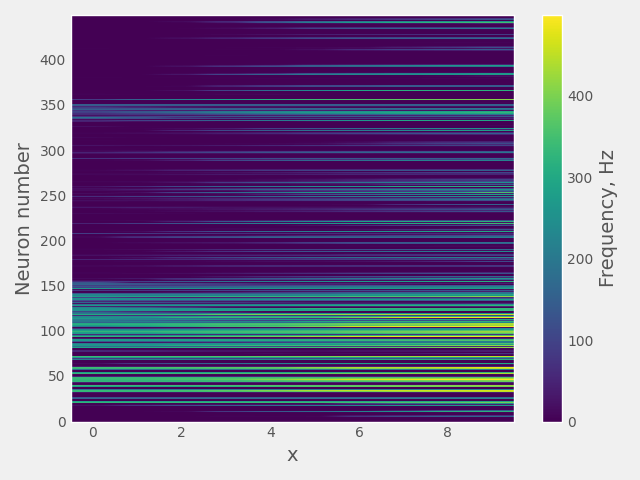

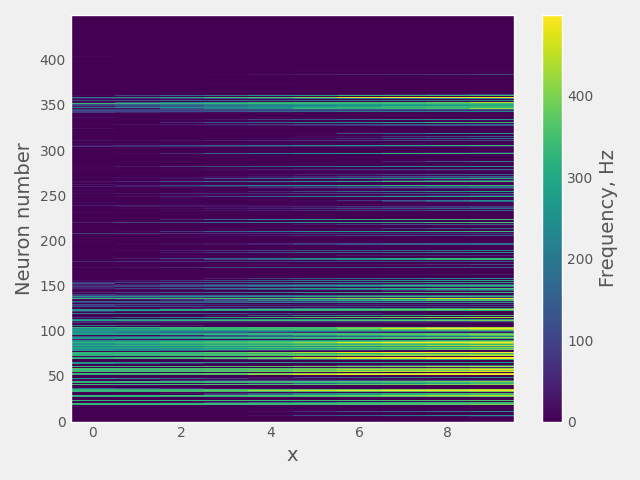

In [168]:
Neurons_frequency_fixation = torch.from_numpy(Neurons_frequency_fixation)
Neurons_frequency_fixation_sort = torch.zeros_like(Neurons_frequency_fixation_copy)

list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_fixation_sort[i] = Neurons_frequency_fixation[
        list_numbers_sort[i]
    ]


plt.imshow(Neurons_frequency_fixation_sort, aspect="auto", origin="lower")
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.grid(False)

plt.tight_layout()
plt.savefig("Neurons_frequency_fixation_sort_first.pdf")
plt.show()
plt.close()
Neurons_frequency_fixation_sort = torch.zeros_like(Neurons_frequency_fixation)

list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_second, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_fixation_sort[i] = Neurons_frequency_fixation[
        list_numbers_sort[i]
    ]


plt.imshow(
    Neurons_frequency_fixation_sort, aspect="auto", origin="lower", interpolation="None"
)
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.grid(False)
plt.tight_layout()

plt.savefig("Neurons_frequency_fixation_sort_second.pdf")
plt.show()
plt.close()

In [71]:
# Neurons_frequency_answer = torch.from_numpy(Neurons_frequency_answer).type(torch.float)
Neurons_frequency_answer_sort = torch.zeros_like(Neurons_frequency_answer)
list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_answer_sort[i] = Neurons_frequency_answer[list_numbers_sort[i]]
plt.figure()
plt.imshow(
    Neurons_frequency_answer_sort, aspect="auto", origin="lower", extent=[0, 10, 1, 401]
)
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_answer_sort_first.pdf")
plt.show()
plt.close()

# Neurons_frequency_answer = torch.from_numpy(Neurons_frequency_answer).type(torch.float)
Neurons_frequency_answer_sort = torch.zeros_like(Neurons_frequency_answer)
list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_second, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_answer_sort[i] = Neurons_frequency_answer[list_numbers_sort[i]]
plt.figure()
plt.imshow(
    Neurons_frequency_answer_sort, aspect="auto", origin="lower", extent=[0, 10, 1, 401]
)
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_answer_sort_second.pdf")
plt.show()
plt.close()

TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
Neurons_frequency_answer_sort.shape

In [ ]:
plt.imshow(Neurons_frequency_answer, aspect="auto", origin="lower")
plt.colorbar()

In [ ]:
for i in range(10, 20):
    plt.plot(Neurons_frequency_answer_copy[i, :])

In [ ]:
plt.figure()
plt.plot(strenght_second_sort.numpy())

In [72]:
rec_weights_sort
A_1_answer = [*torch.where(strenght_first_sort > 0)[0].type(torch.int).numpy()]
A_2_answer = [*torch.where(strenght_second_sort > 0)[0].type(torch.int).numpy()]

A_fix = [*torch.where(fixation_first > 0)[0].type(torch.int).numpy()]
################################################################A_1_answer = list(set(A_1_answer) - set(A_fix))
# A_2_answer = list(set(A_2_answer) - set(A_fix))
set_full_neurons = set([i for i in range(hidden_size)])
active_neurons = set((*A_1_answer, *A_2_answer, *A_fix))
usless_neurons = list(set_full_neurons - active_neurons)
len(usless_neurons)

146

In [73]:
input_1_to_fix = torch.mean(input_sort_1[A_fix])
input_2_to_fix = torch.mean(input_sort_2[A_fix])
input_1_to_1_answ = torch.mean(input_sort_1[A_1_answer])
input_2_to_1_answ = torch.mean(input_sort_2[A_1_answer])
input_1_to_2_answ = torch.mean(input_sort_1[A_2_answer])
input_2_to_2_answ = torch.mean(input_sort_2[A_2_answer])
input_1_to_usles = torch.mean(input_sort_1[usless_neurons])
input_2_to_usles = torch.mean(input_sort_2[usless_neurons])

answ_1_to_fix = torch.mean(rec_weights_sort[:, A_1_answer][A_fix, :])
answ_2_to_fix = torch.mean(rec_weights_sort[:, A_2_answer][A_fix, :])
fix_to_answ_1 = torch.mean(rec_weights_sort[:, A_fix][A_1_answer, :])
fix_to_answ_2 = torch.mean(rec_weights_sort[:, A_fix][A_2_answer, :])

answ_1_to_answ_2 = torch.mean(rec_weights_sort[:, A_1_answer][A_2_answer, :])
answ_2_to_answ_1 = torch.mean(rec_weights_sort[:, A_2_answer][A_1_answer, :])

fix_to_out_0 = torch.mean(out1_sort[A_fix])
fix_to_out_1 = torch.mean(out2_sort[A_fix])
fix_to_out_2 = torch.mean(out3_sort[A_fix])

answ_1_to_out0 = torch.mean(out1_sort[A_1_answer])
answ_2_to_out0 = torch.mean(out1_sort[A_2_answer])


answ_1_to_out1 = torch.mean(out2_sort[A_1_answer])
answ_1_to_out2 = torch.mean(out3_sort[A_1_answer])
answ_2_to_out1 = torch.mean(out2_sort[A_2_answer])
answ_2_to_out2 = torch.mean(out3_sort[A_2_answer])

fix_to_usless = torch.mean(rec_weights_sort[:, A_fix][usless_neurons, :])
answ_1_to_usless = torch.mean(rec_weights_sort[:, A_1_answer][usless_neurons, :])
answ_2_to_usless = torch.mean(rec_weights_sort[:, A_2_answer][usless_neurons, :])


usless_to_out_1 = torch.mean(out1_sort[usless_neurons])
usless_to_out_2 = torch.mean(out2_sort[usless_neurons])
usless_to_out_3 = torch.mean(out3_sort[usless_neurons])

usless_to_fix = torch.mean(rec_weights_sort[:, usless_neurons][A_fix, :])
usless_to_answ_1 = torch.mean(rec_weights_sort[:, usless_neurons][A_1_answer, :])
usless_to_answ_2 = torch.mean(rec_weights_sort[:, usless_neurons][A_2_answer, :])

fix_to_fix = torch.mean(rec_weights_sort[A_fix, :][:, A_fix])
answ_1_to_answ_1 = torch.mean(rec_weights_sort[:, A_1_answer][A_1_answer, :])
answ_2_to_answ_2 = torch.mean(rec_weights_sort[:, A_2_answer][A_2_answer, :])
usless_to_usless = torch.mean(rec_weights_sort[:, usless_neurons][usless_neurons, :])

print(f"in_1 -> fix: {input_1_to_fix}")
print(f"in_2 -> fix: {input_2_to_fix}")
print(f"in_1 -> first answ: {input_1_to_1_answ}")
print(f"in_2 -> first answ: {input_2_to_1_answ}")
print(f"in_1 -> second answ: {input_1_to_2_answ}")
print(f"in_2 -> second answ: {input_2_to_2_answ}")
print(f"in_1 -> usles: {input_1_to_usles}")
print(f"in_2 -> usles: {input_2_to_usles}")

print(f"fix -> answ 1: {fix_to_answ_1}")
print(f"fix -> answ 2: {fix_to_answ_2}")
print(f"fix -> usles 1: {fix_to_usless}")
print(f"answ_1 -> usles: {answ_1_to_usless}")
print(f"answ_2 -> usles: {answ_2_to_usless}")
print(f"answ 1 -> answ 2: {answ_1_to_answ_2}")
print(f"answ 2 -> answ 1: {answ_2_to_answ_1}")

print(f"usless -> fix: {usless_to_fix}")
print(f"usless -> answ 1: {usless_to_answ_1}")
print(f"usless -> answ 2: {usless_to_answ_2}")
print(f"fix -> out 1: {fix_to_out_0}")
print(f"fix -> out 2: {fix_to_out_1}")
print(f"fix -> out 3: {fix_to_out_2}")


print(f"answ 1 -> out 1: {answ_1_to_out0}")
print(f"answ 2 -> out 1: {answ_2_to_out0}")
print(f"answ 1 -> out 2: {answ_1_to_out1}")
print(f"answ 2 -> out 2: {answ_2_to_out1}")
print(f"answ 1 -> out 3: {answ_1_to_out2}")
print(f"answ 2 -> out 3: {answ_2_to_out2}")
print(f"usless -> out 1: {usless_to_out_1}")
print(f"usless -> out 2: {usless_to_out_2}")
print(f"usless -> out 3: {usless_to_out_3}")

print(f"fix -> fix: {fix_to_fix}")
print(f"answ 1 -> answ 1: {answ_1_to_answ_1}")
print(f"answ 2 -> answ 2: {answ_2_to_answ_2}")
print(f"usless -> usless: {usless_to_usless}")

in_1 -> fix: -0.0028884646017104387
in_2 -> fix: -0.005940473172813654
in_1 -> first answ: -0.09423277527093887
in_2 -> first answ: -0.002066165441647172
in_1 -> second answ: -0.15812888741493225
in_2 -> second answ: -0.04404379054903984
in_1 -> usles: 0.07821941375732422
in_2 -> usles: 0.016938192769885063
fix -> answ 1: -0.007117065601050854
fix -> answ 2: -0.006729693152010441
fix -> usles 1: -0.0014987908070906997
answ_1 -> usles: -0.002519801026210189
answ_2 -> usles: -0.002800123766064644
answ 1 -> answ 2: -0.0022792606614530087
answ 2 -> answ 1: -0.006155059207230806
usless -> fix: -0.0028994271997362375
usless -> answ 1: -0.00524379126727581
usless -> answ 2: -0.0029492906760424376
fix -> out 1: -0.002741609700024128
fix -> out 2: 0.002539797918871045
fix -> out 3: 0.0053505864925682545
answ 1 -> out 1: -0.012282107956707478
answ 2 -> out 1: -0.020887186750769615
answ 1 -> out 2: 0.019137665629386902
answ 2 -> out 2: 0.003868347965180874
answ 1 -> out 3: -0.001075603999197483
a

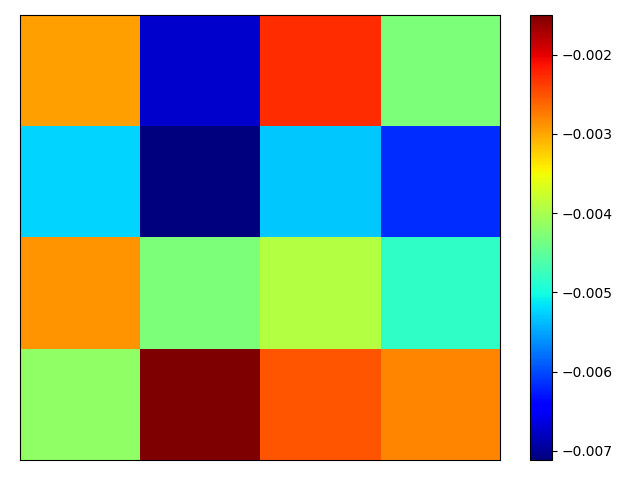

In [74]:
Matrix_blocks = np.zeros((4, 4))
Matrix_blocks[0, 0] = usless_to_usless
Matrix_blocks[1, 1] = fix_to_fix
Matrix_blocks[2, 2] = answ_1_to_answ_1
Matrix_blocks[3, 3] = answ_2_to_answ_2

Matrix_blocks[0, 1] = usless_to_fix
Matrix_blocks[0, 2] = usless_to_answ_1
Matrix_blocks[0, 3] = usless_to_answ_2

Matrix_blocks[1, 0] = fix_to_usless
Matrix_blocks[1, 2] = fix_to_answ_1
Matrix_blocks[1, 3] = fix_to_answ_2

Matrix_blocks[2, 0] = answ_1_to_usless
Matrix_blocks[2, 1] = answ_1_to_fix
Matrix_blocks[2, 3] = answ_1_to_answ_2
Matrix_blocks[3, 0] = answ_2_to_usless
Matrix_blocks[3, 1] = answ_2_to_fix
Matrix_blocks[3, 2] = answ_2_to_answ_1

plt.figure()
plt.imshow(
    Matrix_blocks.T, aspect="auto", origin="lower", interpolation="nearest", cmap="jet"
)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.savefig("blocks.pdf")

plt.show()

In [75]:
input_1_to_fix = torch.sum(input_sort_1[A_fix])
input_2_to_fix = torch.sum(input_sort_2[A_fix])
input_1_to_1_answ = torch.sum(input_sort_1[A_1_answer])
input_2_to_1_answ = torch.sum(input_sort_2[A_1_answer])
input_1_to_2_answ = torch.sum(input_sort_1[A_2_answer])
input_2_to_2_answ = torch.sum(input_sort_2[A_2_answer])
input_1_to_usles = torch.sum(input_sort_1[usless_neurons])
input_2_to_usles = torch.sum(input_sort_2[usless_neurons])

answ_1_to_fix = torch.sum(rec_weights_sort[:, A_1_answer][A_fix, :])
answ_2_to_fix = torch.sum(rec_weights_sort[:, A_2_answer][A_fix, :])
fix_to_answ_1 = torch.sum(rec_weights_sort[:, A_fix][A_1_answer, :])
fix_to_answ_2 = torch.sum(rec_weights_sort[:, A_fix][A_2_answer, :])

answ_1_to_answ_2 = torch.sum(rec_weights_sort[:, A_1_answer][A_2_answer, :])
answ_2_to_answ_1 = torch.sum(rec_weights_sort[:, A_2_answer][A_1_answer, :])

fix_to_out_0 = torch.sum(out1_sort[A_fix])
fix_to_out_1 = torch.sum(out2_sort[A_fix])
fix_to_out_2 = torch.sum(out3_sort[A_fix])

answ_1_to_out0 = torch.sum(out1_sort[A_1_answer])
answ_2_to_out0 = torch.sum(out1_sort[A_2_answer])


answ_1_to_out1 = torch.sum(out2_sort[A_1_answer])
answ_1_to_out2 = torch.sum(out3_sort[A_1_answer])
answ_2_to_out1 = torch.sum(out2_sort[A_2_answer])
answ_2_to_out2 = torch.sum(out3_sort[A_2_answer])

fix_to_usless = torch.sum(rec_weights_sort[:, A_fix][usless_neurons, :])
answ_1_to_usless = torch.sum(rec_weights_sort[:, A_1_answer][usless_neurons, :])
answ_2_to_usless = torch.sum(rec_weights_sort[:, A_2_answer][usless_neurons, :])


usless_to_out_1 = torch.sum(out1_sort[usless_neurons])
usless_to_out_2 = torch.sum(out2_sort[usless_neurons])
usless_to_out_3 = torch.sum(out3_sort[usless_neurons])

usless_to_fix = torch.sum(rec_weights_sort[:, usless_neurons][A_fix, :])
usless_to_answ_1 = torch.sum(rec_weights_sort[:, usless_neurons][A_1_answer, :])
usless_to_answ_2 = torch.sum(rec_weights_sort[:, usless_neurons][A_2_answer, :])

fix_to_fix = torch.sum(rec_weights_sort[A_fix, :][:, A_fix])
answ_1_to_answ_1 = torch.sum(rec_weights_sort[:, A_1_answer][A_1_answer, :])
answ_2_to_answ_2 = torch.sum(rec_weights_sort[:, A_2_answer][A_2_answer, :])
usless_to_usless = torch.sum(rec_weights_sort[:, usless_neurons][usless_neurons, :])

print(f"in_1 -> fix: {input_1_to_fix}")
print(f"in_2 -> fix: {input_2_to_fix}")
print(f"in_1 -> first answ: {input_1_to_1_answ}")
print(f"in_2 -> first answ: {input_2_to_1_answ}")
print(f"in_1 -> second answ: {input_1_to_2_answ}")
print(f"in_2 -> second answ: {input_2_to_2_answ}")
print(f"in_1 -> usles: {input_1_to_usles}")
print(f"in_2 -> usles: {input_2_to_usles}")

print(f"fix -> answ 1: {fix_to_answ_1}")
print(f"fix -> answ 2: {fix_to_answ_2}")
print(f"fix -> usles 1: {fix_to_usless}")
print(f"answ_1 -> usles: {answ_1_to_usless}")
print(f"answ_2 -> usles: {answ_2_to_usless}")
print(f"answ 1 -> answ 2: {answ_1_to_answ_2}")
print(f"answ 2 -> answ 1: {answ_2_to_answ_1}")

print(f"usless -> fix: {usless_to_fix}")
print(f"usless -> answ 1: {usless_to_answ_1}")
print(f"usless -> answ 2: {usless_to_answ_2}")
print(f"fix -> out 1: {fix_to_out_0}")
print(f"fix -> out 2: {fix_to_out_1}")
print(f"fix -> out 3: {fix_to_out_2}")


print(f"answ 1 -> out 1: {answ_1_to_out0}")
print(f"answ 2 -> out 1: {answ_2_to_out0}")
print(f"answ 1 -> out 2: {answ_1_to_out1}")
print(f"answ 2 -> out 2: {answ_2_to_out1}")
print(f"answ 1 -> out 3: {answ_1_to_out2}")
print(f"answ 2 -> out 3: {answ_2_to_out2}")
print(f"usless -> out 1: {usless_to_out_1}")
print(f"usless -> out 2: {usless_to_out_2}")
print(f"usless -> out 3: {usless_to_out_3}")

print(f"fix -> fix: {fix_to_fix}")
print(f"answ 1 -> answ 1: {answ_1_to_answ_1}")
print(f"answ 2 -> answ 2: {answ_2_to_answ_2}")
print(f"usless -> usless: {usless_to_usless}")

in_1 -> fix: -0.6614583730697632
in_2 -> fix: -1.3603683710098267
in_1 -> first answ: -13.192588806152344
in_2 -> first answ: -0.28926315903663635
in_1 -> second answ: -11.543408393859863
in_2 -> second answ: -3.2151966094970703
in_1 -> usles: 11.420034408569336
in_2 -> usles: 2.4729762077331543
fix -> answ 1: -228.17312622070312
fix -> answ 2: -112.50028228759766
fix -> usles 1: -50.110572814941406
answ_1 -> usles: -51.50473403930664
answ_2 -> usles: -29.843719482421875
answ 1 -> answ 2: -23.294044494628906
answ 2 -> answ 1: -62.90470504760742
usless -> fix: -96.93944549560547
usless -> answ 1: -107.18309783935547
usless -> answ 2: -31.43354034423828
fix -> out 1: -0.6278285980224609
fix -> out 2: 0.5816137194633484
fix -> out 3: 1.2252843379974365
answ 1 -> out 1: -1.7194950580596924
answ 2 -> out 1: -1.5247646570205688
answ 1 -> out 2: 2.6792731285095215
answ 2 -> out 2: 0.28238940238952637
answ 1 -> out 3: -0.15058456361293793
answ 2 -> out 3: 1.790850043296814
usless -> out 1: 0.5

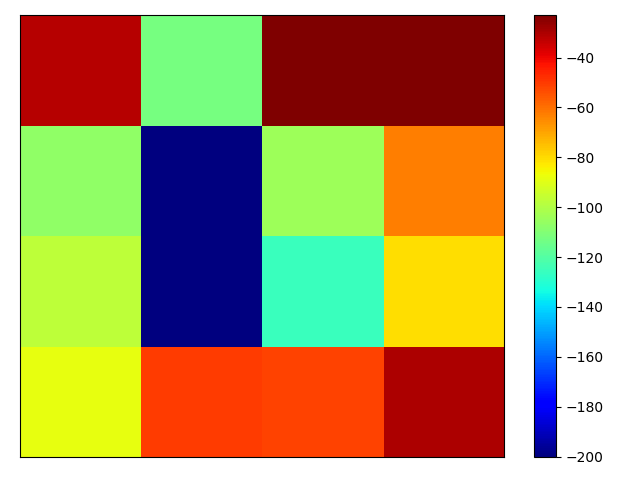

In [76]:
Matrix_blocks = np.zeros((4, 4))
Matrix_blocks[0, 0] = usless_to_usless
Matrix_blocks[1, 1] = fix_to_fix
Matrix_blocks[2, 2] = answ_1_to_answ_1
Matrix_blocks[3, 3] = answ_2_to_answ_2

Matrix_blocks[0, 1] = usless_to_fix
Matrix_blocks[0, 2] = usless_to_answ_1
Matrix_blocks[0, 3] = usless_to_answ_2

Matrix_blocks[1, 0] = fix_to_usless
Matrix_blocks[1, 2] = fix_to_answ_1
Matrix_blocks[1, 3] = fix_to_answ_2

Matrix_blocks[2, 0] = answ_1_to_usless
Matrix_blocks[2, 1] = answ_1_to_fix
Matrix_blocks[2, 3] = answ_1_to_answ_2
Matrix_blocks[3, 0] = answ_2_to_usless
Matrix_blocks[3, 1] = answ_2_to_fix
Matrix_blocks[3, 2] = answ_2_to_answ_1

plt.figure()
plt.imshow(
    Matrix_blocks.T,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    cmap="jet",
    vmin=-200,
)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.savefig("blocks.pdf")

plt.show()